# Introduction
Here, we will use vector search on time series data to predict the weather in the next hour. Our data will come from the [Jena Climate dataset](https://www.kaggle.com/stytch16/jena-climate-2009-2016). This dataset is made up of quantities such as air temperature, atmospheric pressure, humidity, etc. that were recorded every 10 minutes over the course of several years.

We can treat each column as a feature vector identified by the time stamp associated with them. These will constitute the vectors that we perform our search with, and the nearest neighbors will give us an idea of what the weather will be for that hour. Although this is a very simple embedding process, we want to demonstrate how effective even a simple vector search with Lantern can be.

# Setup Postgres

We install postgres and its dev tools (necessary to build lantern from source). We also start postgres, and set up a user 'postgres' with password 'postgres' and create a database called 'ourdb'




In [ ]:
# We install postgres and its dev tools
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql postgresql-server-dev-all
#  Start postgres
!sudo service postgresql start

# Create user, password, and db
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS ourdb;'
!sudo -u postgres psql -U postgres -c 'CREATE DATABASE ourdb;'

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 26.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package logrotate.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../00-logrotate_3.19.0-1ubuntu1.1_amd64.deb ...
Unpacking logrotate (3.19.0-1ubuntu1.1) ...
Selecting previously unselected package netbase.
Preparing to unpack .../01-netbase_6.3_all.deb ...
Unpacking netbase (6.3) ...
Selecting previously unselected package python3-yaml.
Preparing to unpack .../02-python3-yaml_5.4.1-1ubuntu1_amd64.deb ...
Unpacking python3-yaml (5.4.1-1ubuntu1) ...
Selecting previous

# Install Lantern and build it from source

In [ ]:
!git clone --recursive https://github.com/lanterndata/lantern.git

Cloning into 'lantern'...
remote: Enumerating objects: 2562, done.
remote: Counting objects: 100% (1358/1358), done.
remote: Compressing objects: 100% (440/440), done.
remote: Total 2562 (delta 1073), reused 994 (delta 912), pack-reused 1204
Receiving objects: 100% (2562/2562), 588.10 KiB | 2.21 MiB/s, done.
Resolving deltas: 100% (1689/1689), done.
Submodule 'third_party/hnswlib' (https://github.com/ngalstyan4/hnswlib) registered for path 'third_party/hnswlib'
Submodule 'third_party/usearch' (https://github.com/ngalstyan4/usearch) registered for path 'third_party/usearch'
Cloning into '/content/lantern/third_party/hnswlib'...
remote: Enumerating objects: 1723, done.        
remote: Counting objects: 100% (343/343), done.        
remote: Compressing objects: 100% (43/43), done.        
remote: Total 1723 (delta 314), reused 300 (delta 300), pack-reused 1380        
Receiving objects: 100% (1723/1723), 528.17 KiB | 2.49 MiB/s, done.
Resolving deltas: 100% (1096/1096), done.
Cloning into

In [ ]:
# We build lantern from source
%cd lantern
!mkdir build
%cd build
!pwd
!cmake ..
!make install

/content/lantern
/content/lantern/build
/content/lantern/build
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Build type: 
-- Found pg_config as /usr/bin/pg_config
-- Found postgres binary at /usr/lib/postgresql/14/bin/postgres
-- P

# Loading Data and Preprocessing


Let's first import our dependencies

In [ ]:
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import List
import itertools
import os

mpl.rcParams['figure.figsize'] = (20, 16)
mpl.rcParams['axes.grid'] = False

### Load dataset

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 1s 0us/step


### Preprocessing
Let's load the hourly data into a datafame, and then separate it into data that we will insert into Lantern ("train data") and data that we will use to query ("test data")

Note that the number of features is 14, and so our vectors will be of dimension 14.

In [ ]:
original_data_for_insert = pd.read_csv(csv_path)
original_data_for_insert = original_data_for_insert[5::6]

original_data_for_insert['Date Time'] = pd.to_datetime(original_data_for_insert['Date Time'], format='%d.%m.%Y %H:%M:%S')

n = len(original_data_for_insert)
train_data = original_data_for_insert[:int(n*0.9)]
test_data = original_data_for_insert[int(n*0.9):]

train_data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


# Create Postgres Table

Now let's set up `psycopg2` with postgres, and enable the lantern extension


In [ ]:
import psycopg2

# We use the dbname, user, and password that we specified above
conn = psycopg2.connect(
    dbname="ourdb",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432" # default port for Postgres
)

# Get a new cursor
cursor = conn.cursor()

# Execute the query to load the Lantern extension in
cursor.execute("CREATE EXTENSION IF NOT EXISTS lantern;")

conn.commit()
cursor.close()

Now let's create the table that we will use to store these weather data vectors. We'll call the table `weather`, and it will have a primary key `id`, a text string `datetime` for the date-time string, and the weather embedding `vector`. Note that we make `vector` of type real array (`real[]`). We can add a dimension, like `real[14]`, but note that this dimension specified here is just syntactic sugar in postgres, and is not enforced.

In [ ]:
# Create the table
cursor = conn.cursor()

TABLE_NAME = "weather_data"

create_table_query = f"CREATE TABLE {TABLE_NAME} (id serial PRIMARY key, datetime text, vector real[]);"

cursor.execute(create_table_query)

conn.commit()
cursor.close()

# Inserting embeddings into our database
Now that we have a table created, let's insert our weather embeddings that we prepared earlier.


In [ ]:
from tqdm.auto import tqdm

cursor = conn.cursor()

values_tolist = train_data.values.tolist()

for i in tqdm(range(0, len(values_tolist))):
  row = values_tolist[i]
  datetimestring = str(row[0])
  vector = [float(x) for x in row[1:]]
  # Insert this vector and datetime into our db
  cursor.execute(f"INSERT INTO {TABLE_NAME} (datetime, vector) VALUES (%s, %s);", (datetimestring, vector))

conn.commit()
cursor.close()

  0%|          | 0/63081 [00:00<?, ?it/s]

# Creating an Index
Now that we have inserted the embeddings into our database, we need to construct an index in postgres using lantern. This is important because the index will tell allow postgres to use lantern when performing vector search.

Note that we specify cosine distance as the distance metric, because these weather embeddings are not normalized, and the cosine distance is concerned more about capturing the angle of deviation and is less concerned about magnitude.

Also, as a good practice, we specify the dimension of the index (although lantern can infer it from the vectors we've already inserted).

In [ ]:
cursor = conn.cursor()

cursor.execute(f"CREATE INDEX ON {TABLE_NAME} USING hnsw (vector dist_cos_ops) WITH (dim=14);")

conn.commit()
cursor.close()

# Predictions With Vector Search

Now that we have embedded our weather vectors, we can now perform vector search against other queries. Let's get the top candidate in the search for a range of queries from our test data we prepared earlier.

We'll prepare this query data first:

In [ ]:
# Prepare data that we will query
query_dates = []
query_data = []
for row in test_data.values.tolist():
    query_dates.append(str(row[0]))
    query_data.append(row[1:])

Now we can perform queries for each of the queries that we've prepared. We will get the top candidate for each query (including its vector column), specified by `LIMIT 1` in the query (this means we will get the 1 nearest neighbor returned by lantern to the query)

In [ ]:
query_results = []

cursor = conn.cursor()

# We only need to set this at the beginning of a session
cursor.execute("SET enable_seqscan = false;")

for query_raw in tqdm(query_data):
  query_vector = str([float(x) for x in query_raw])
  cursor.execute(f"SELECT vector, datetime FROM {TABLE_NAME} ORDER BY vector <-> ARRAY{query_vector} LIMIT 1;")

  record = cursor.fetchone()
  query_results.append(record)

cursor.close()

  0%|          | 0/7010 [00:00<?, ?it/s]

([1000.67,
  2.93,
  276.03,
  1.14,
  88.0,
  7.54,
  6.64,
  0.9,
  4.13,
  6.63,
  1259.47,
  3.14,
  5.33,
  27.15],
 '2016-03-11 16:00:00')

Now let's write a function to help us get the predicted and true values for a particular feature (one of our weather embedding dimensions). We use our vectors to find the most similar vector in the database and then reading the hour after that.

We also write helper functions to help us visualize our results.

In [ ]:
def get_predictions(feature):

    true_values = []
    predicted_values = []

    for test_date, qr in zip(query_dates, query_results):
        similar_date = qr[1]
        hour_from_original = datetime.strptime(str(test_date), '%Y-%m-%d %H:%M:%S') + timedelta(hours=1)
        hour_from_similar = datetime.strptime(similar_date, '%Y-%m-%d %H:%M:%S') + timedelta(hours=1)

        original_temperature = original_data_for_insert.loc[original_data_for_insert['Date Time'] == hour_from_original][feature].tolist()
        similar_temperature = original_data_for_insert.loc[original_data_for_insert['Date Time'] == hour_from_similar][feature].tolist()

        if original_temperature and similar_temperature:
            true_values.append(original_temperature[0])
            predicted_values.append(similar_temperature[0])
    return true_values, predicted_values


In [ ]:
def plot_results(predicted_values: List, true_values: List):
    x_list = range(0, len(predicted_values))
    plt.plot(x_list[:200], predicted_values[:200], label='forecast')
    plt.plot(x_list[:200], true_values[:200], label='true')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def print_results(true_values: List, predicted_values: List):
    print(f'MSE: {mean_squared_error(true_values, predicted_values)}')
    print(f'RMSE: {mean_squared_error(true_values, predicted_values, squared=False)}')
    print(f'MAE: {mean_absolute_error(true_values, predicted_values)}')

# Results
Let's plot the predicted and true values for all 14 features/dimensions in our data:

Analyzing predictions for p (mbar)


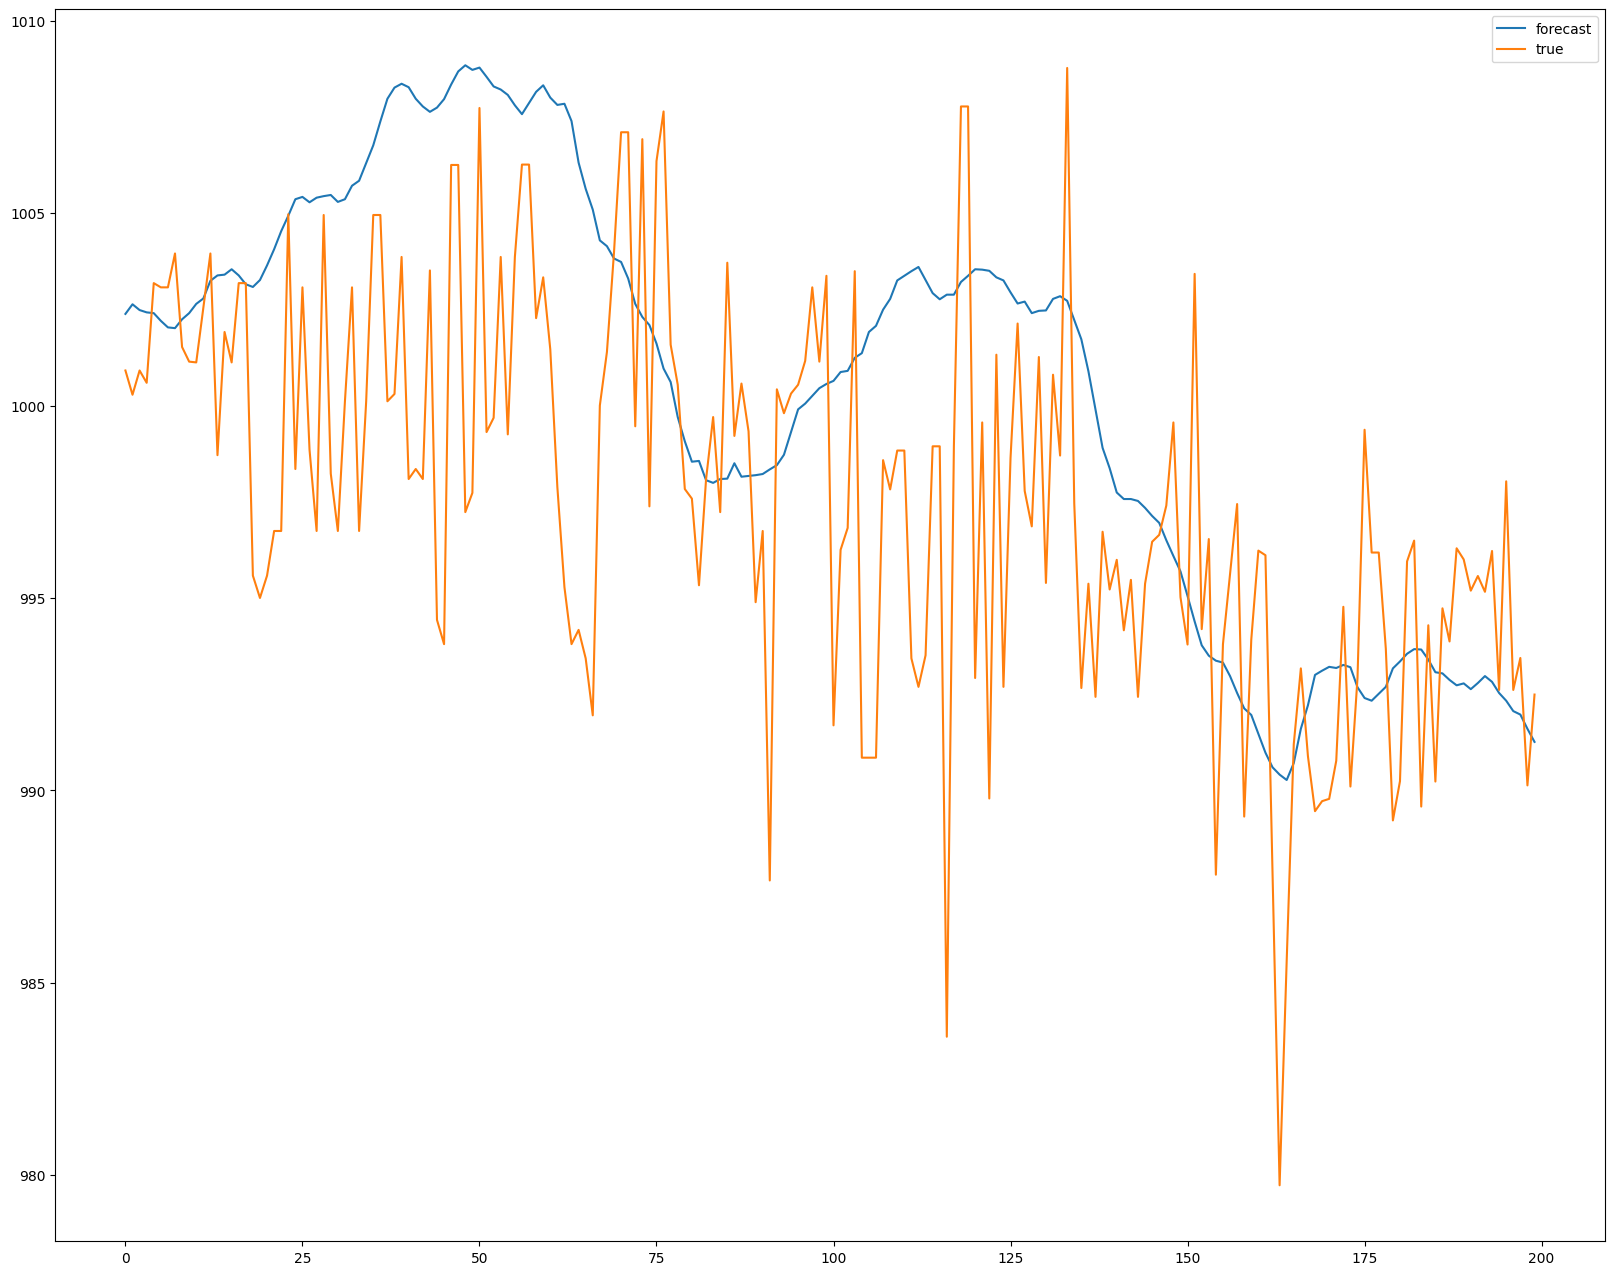

MSE: 22.177379591836733
RMSE: 4.7092865268357516
MAE: 3.6857028685600115
Analyzing predictions for T (degC)


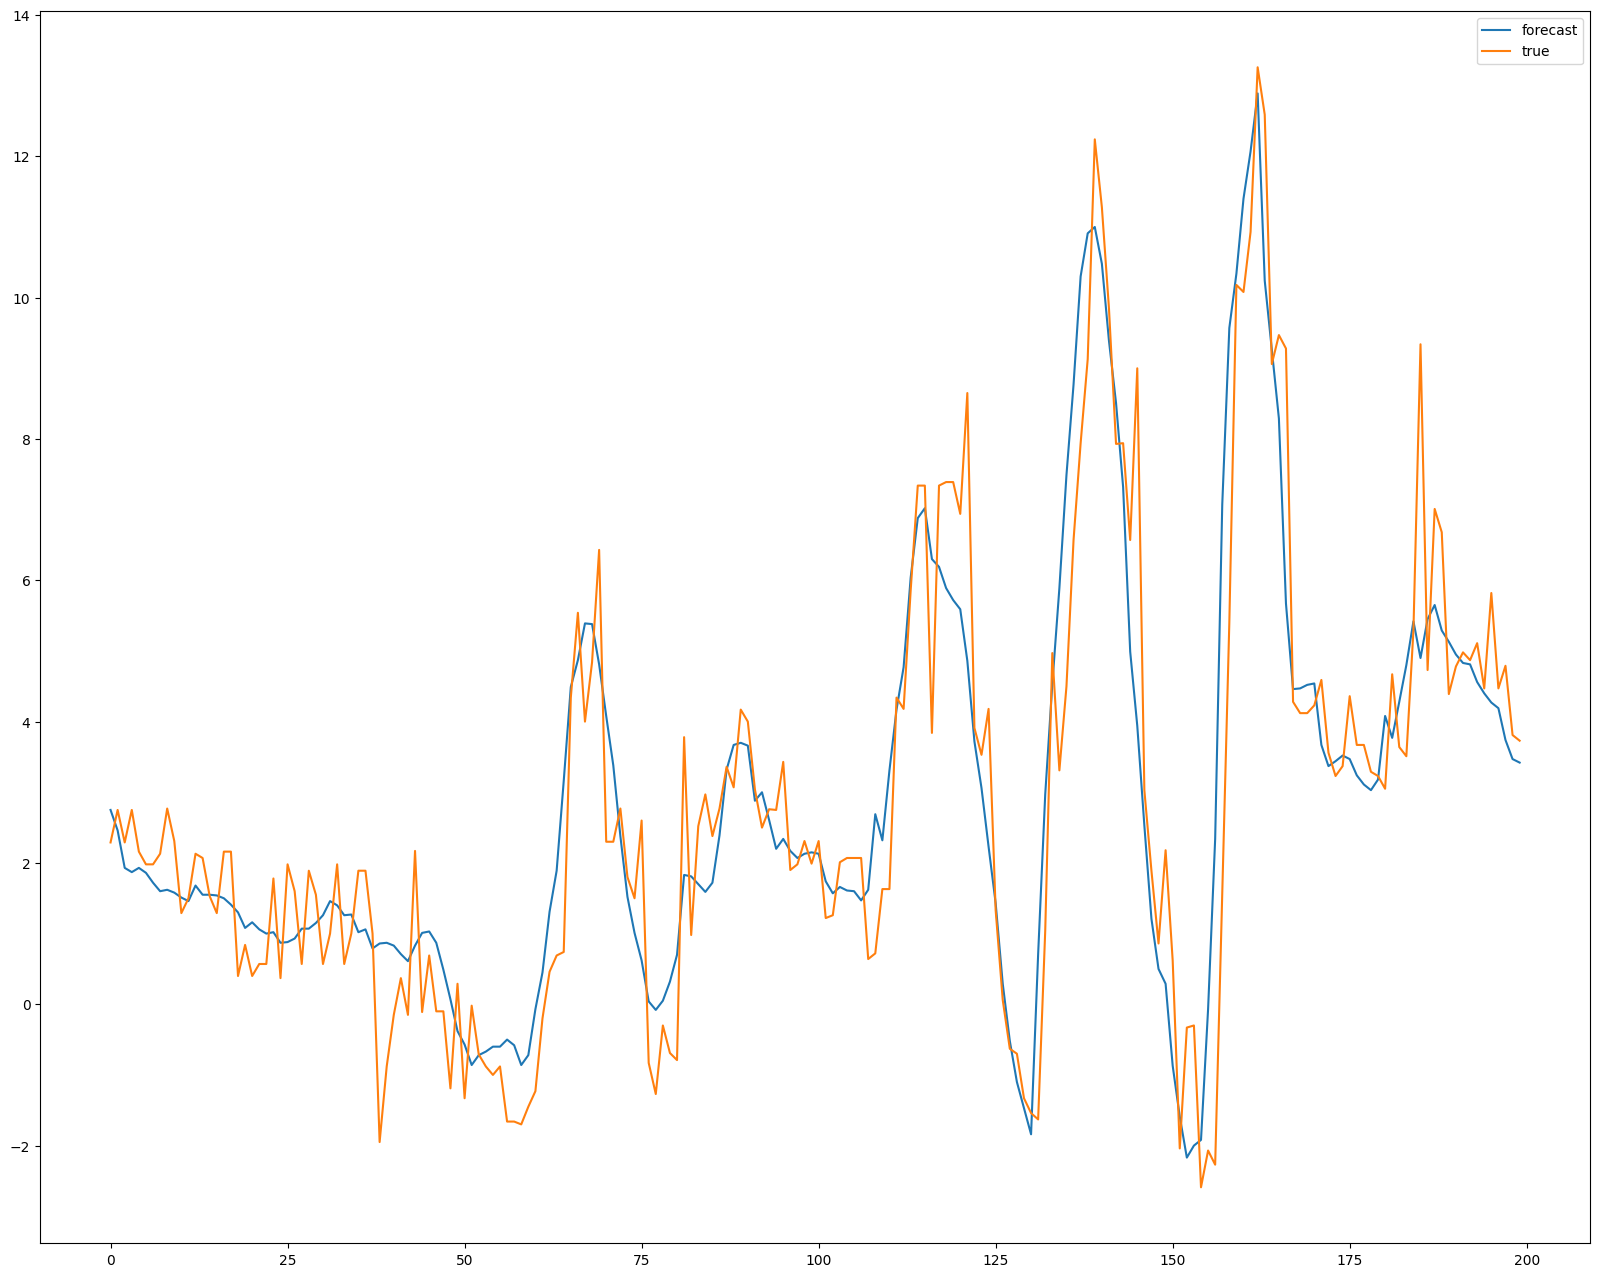

MSE: 2.1224704295704298
RMSE: 1.4568700798528431
MAE: 1.0813286713286714
Analyzing predictions for Tpot (K)


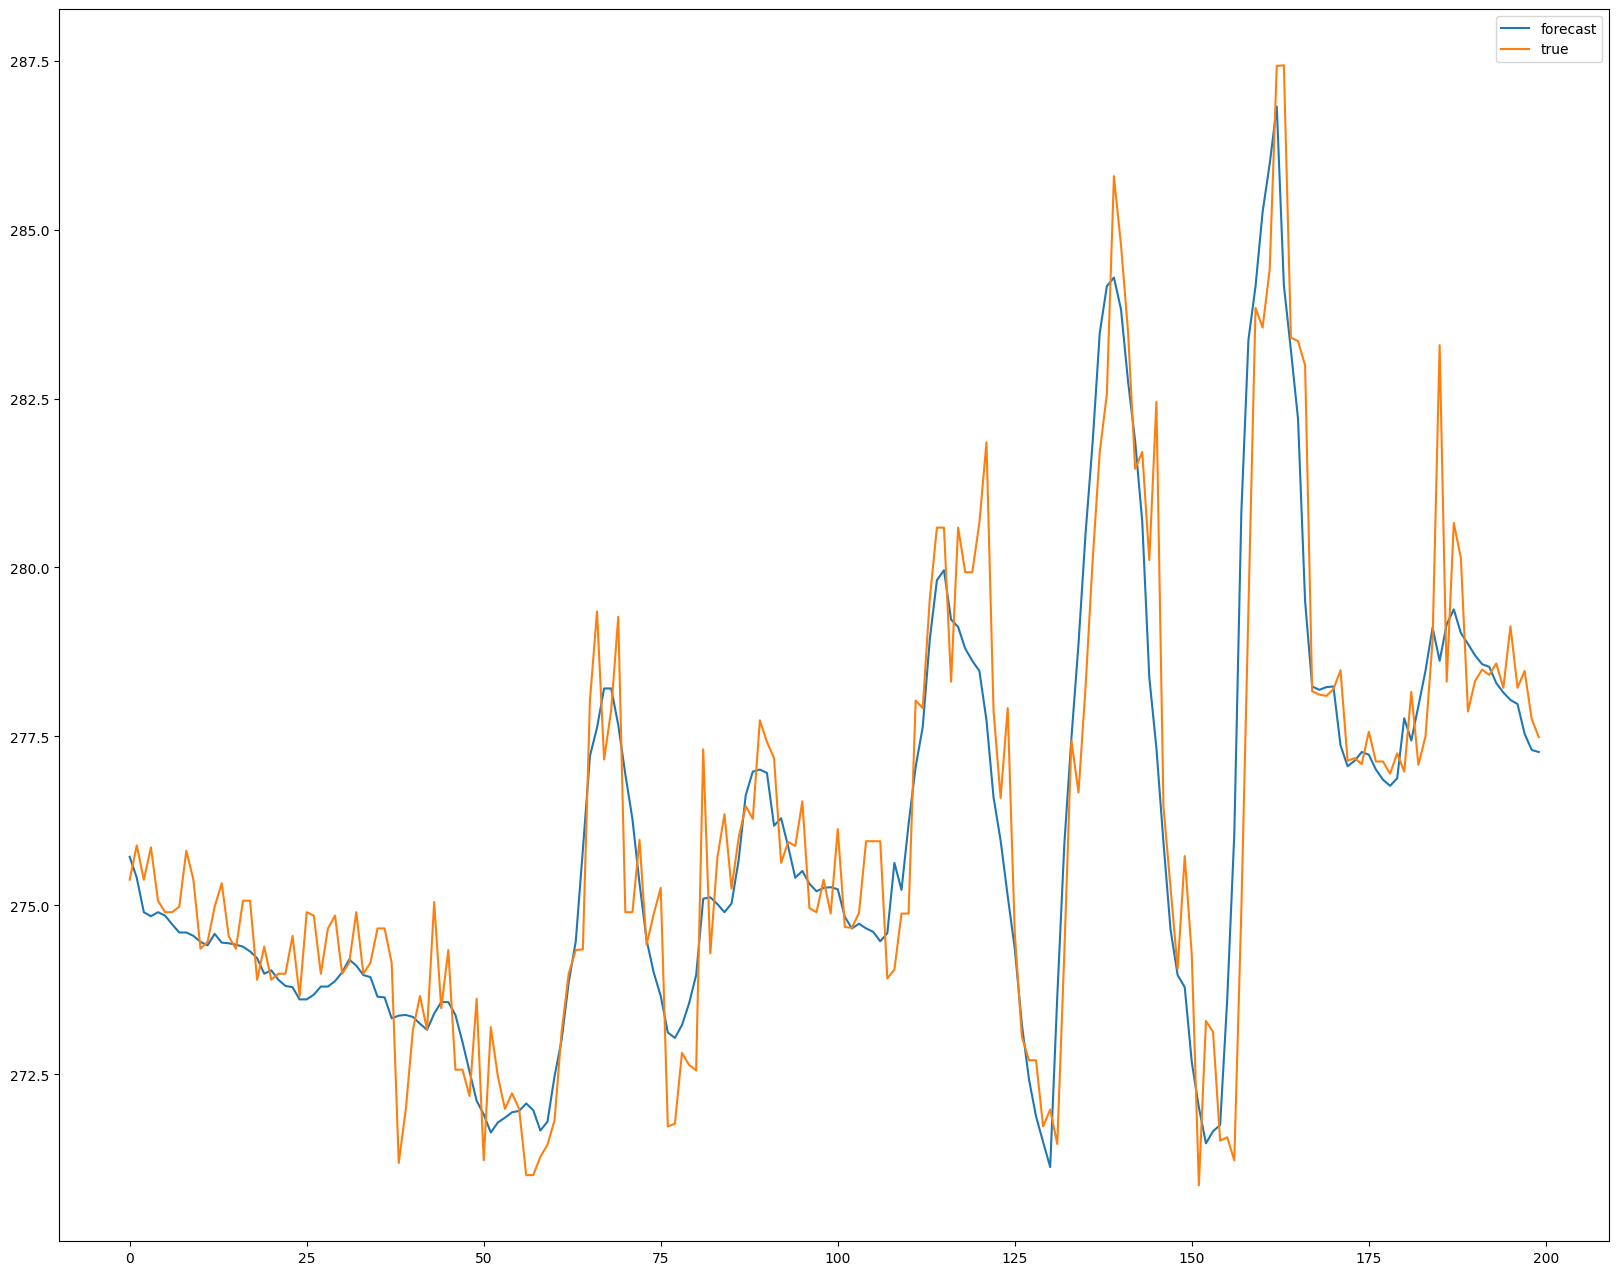

MSE: 2.121695518766947
RMSE: 1.4566041050220018
MAE: 1.0795561581275865
Analyzing predictions for Tdew (degC)


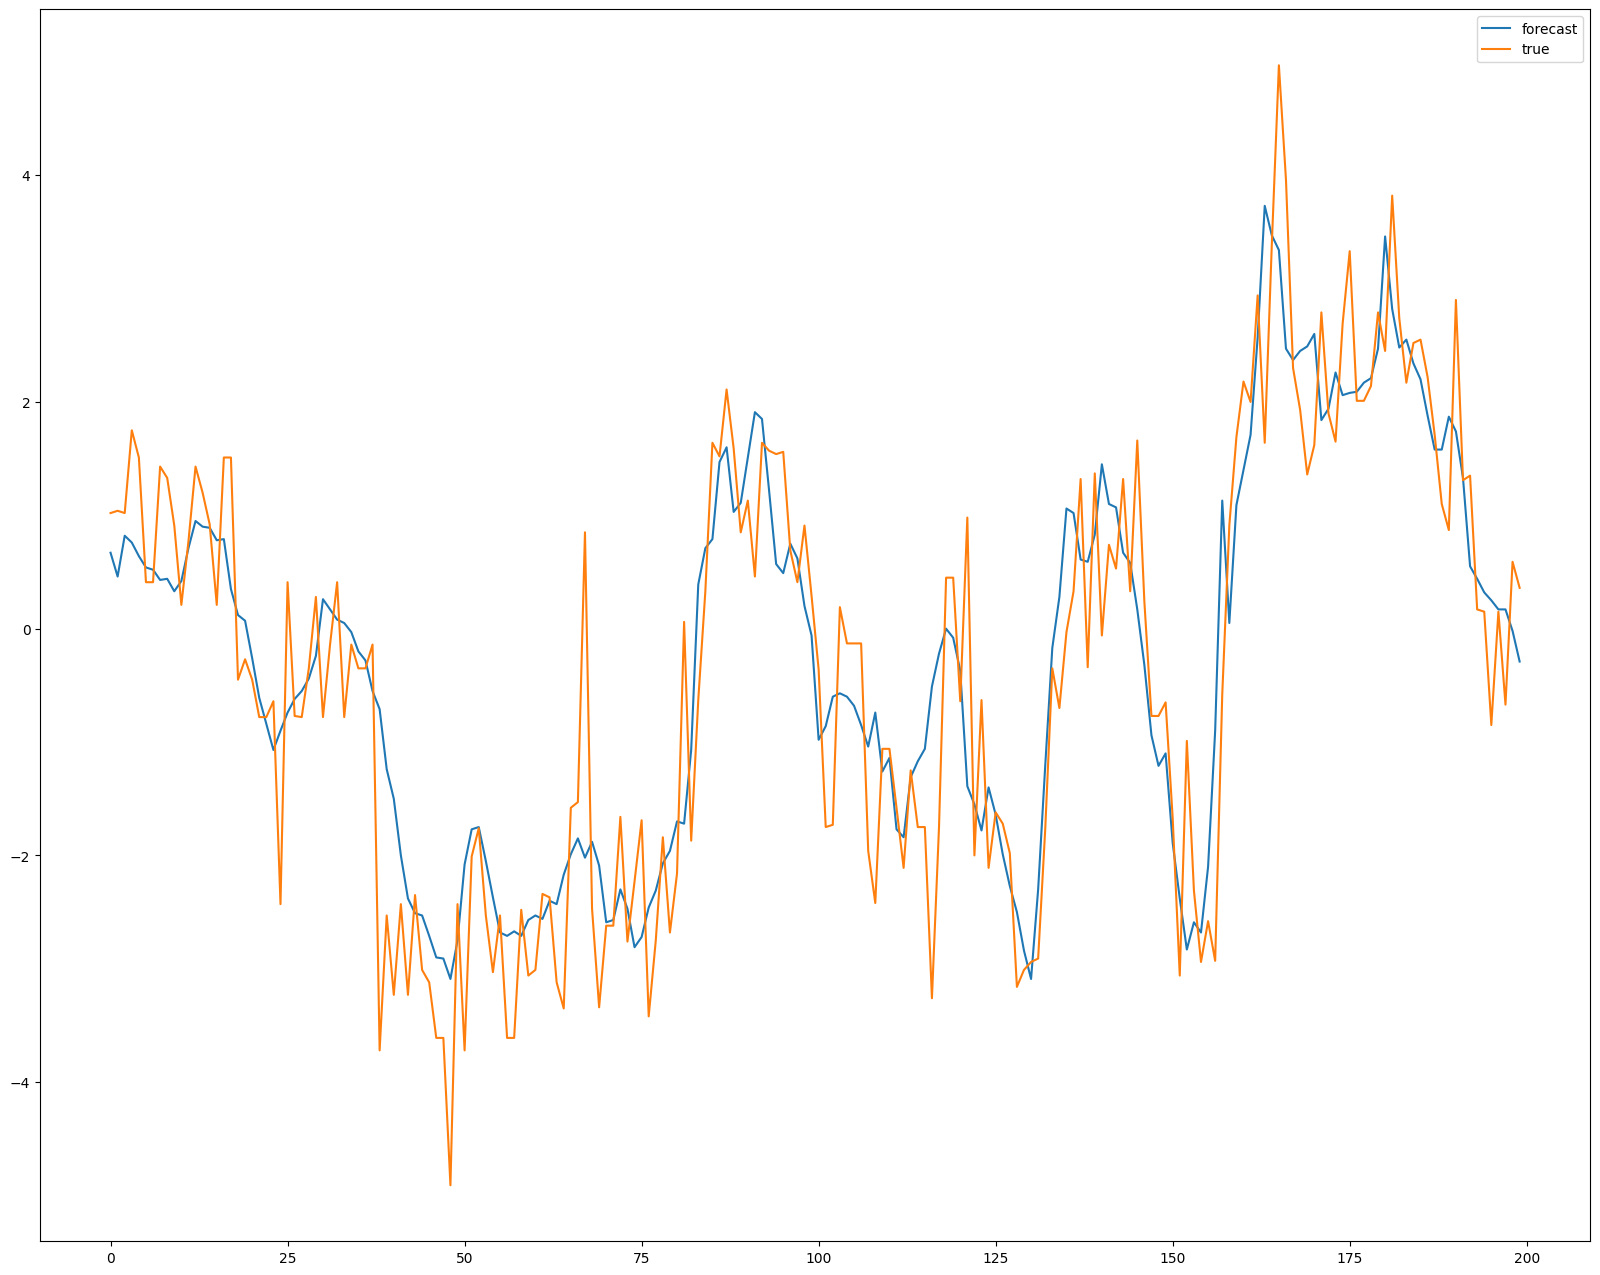

MSE: 0.9457054231482802
RMSE: 0.9724738675914537
MAE: 0.7278592835735692
Analyzing predictions for rh (%)


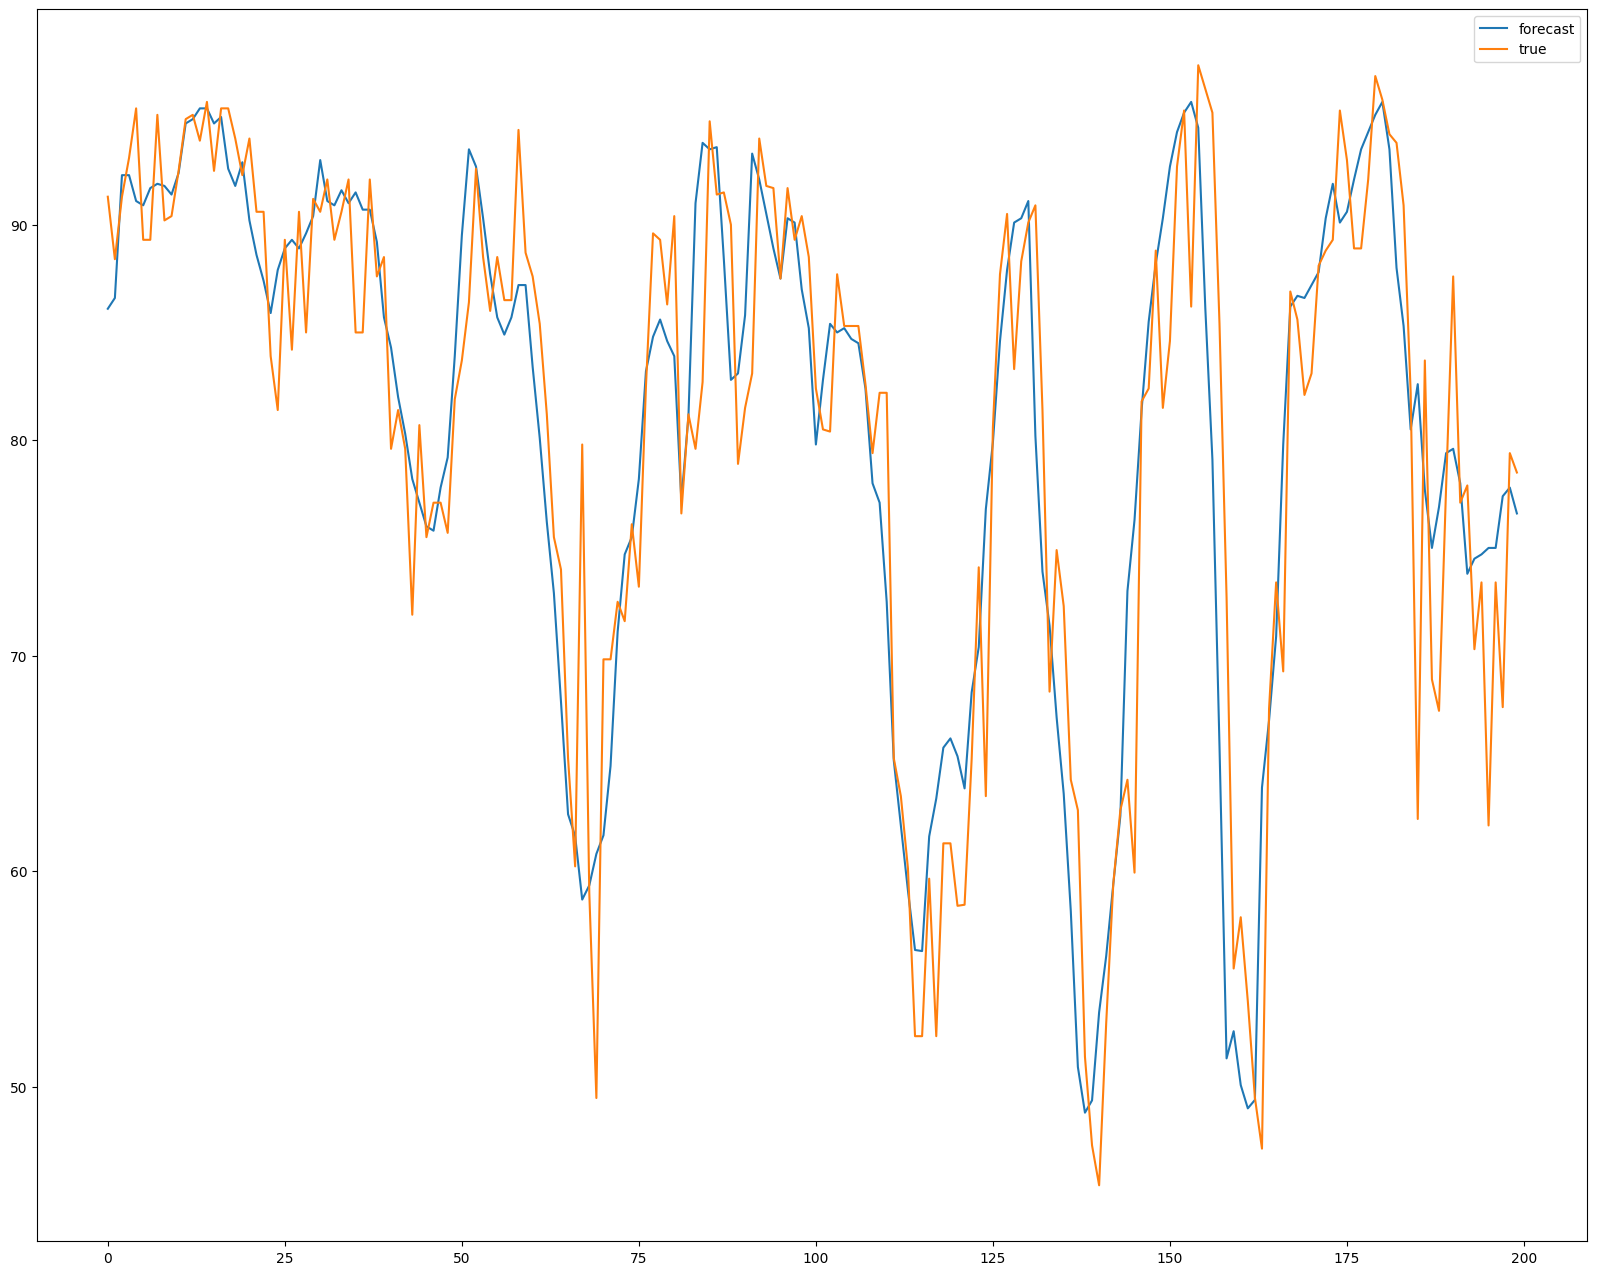

MSE: 41.055295019266445
RMSE: 6.407440598184773
MAE: 4.608017696589125
Analyzing predictions for VPmax (mbar)


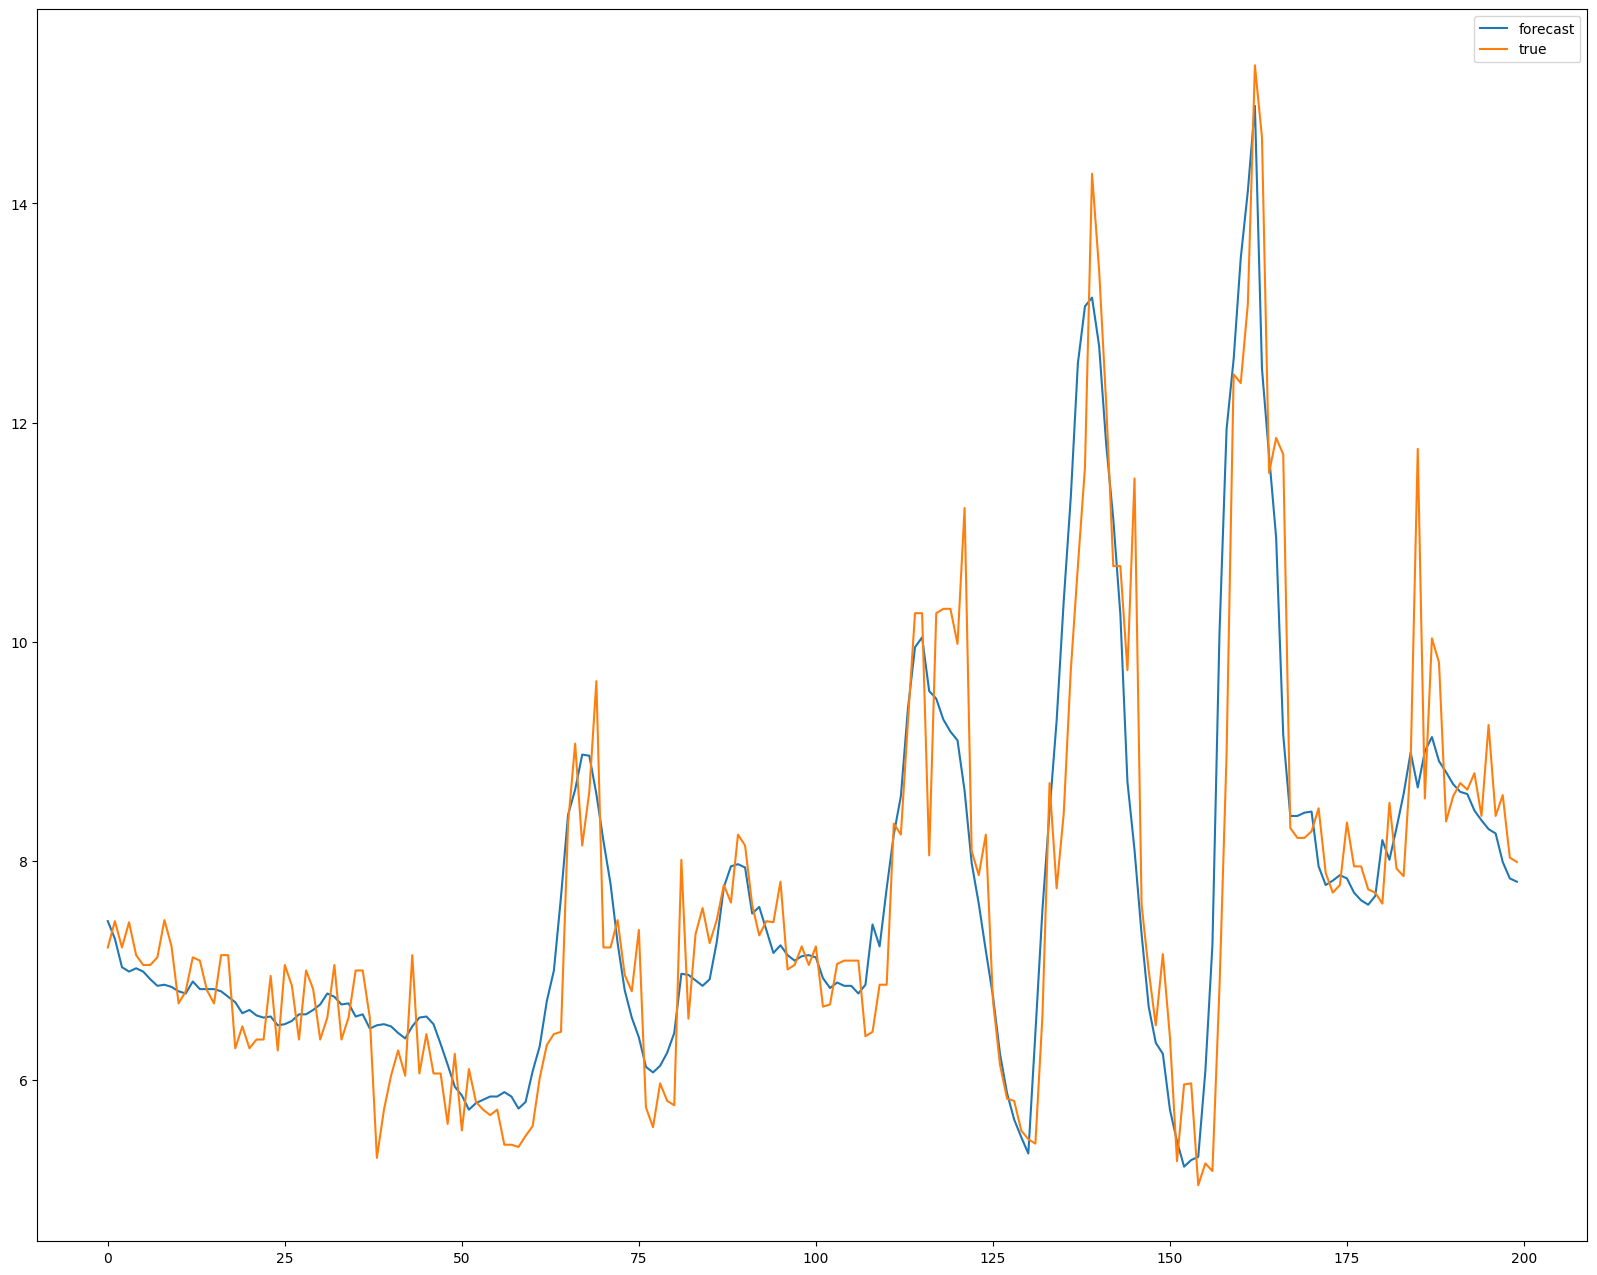

MSE: 3.0695151420008564
RMSE: 1.7520031797918794
MAE: 1.1534265734265734
Analyzing predictions for VPact (mbar)


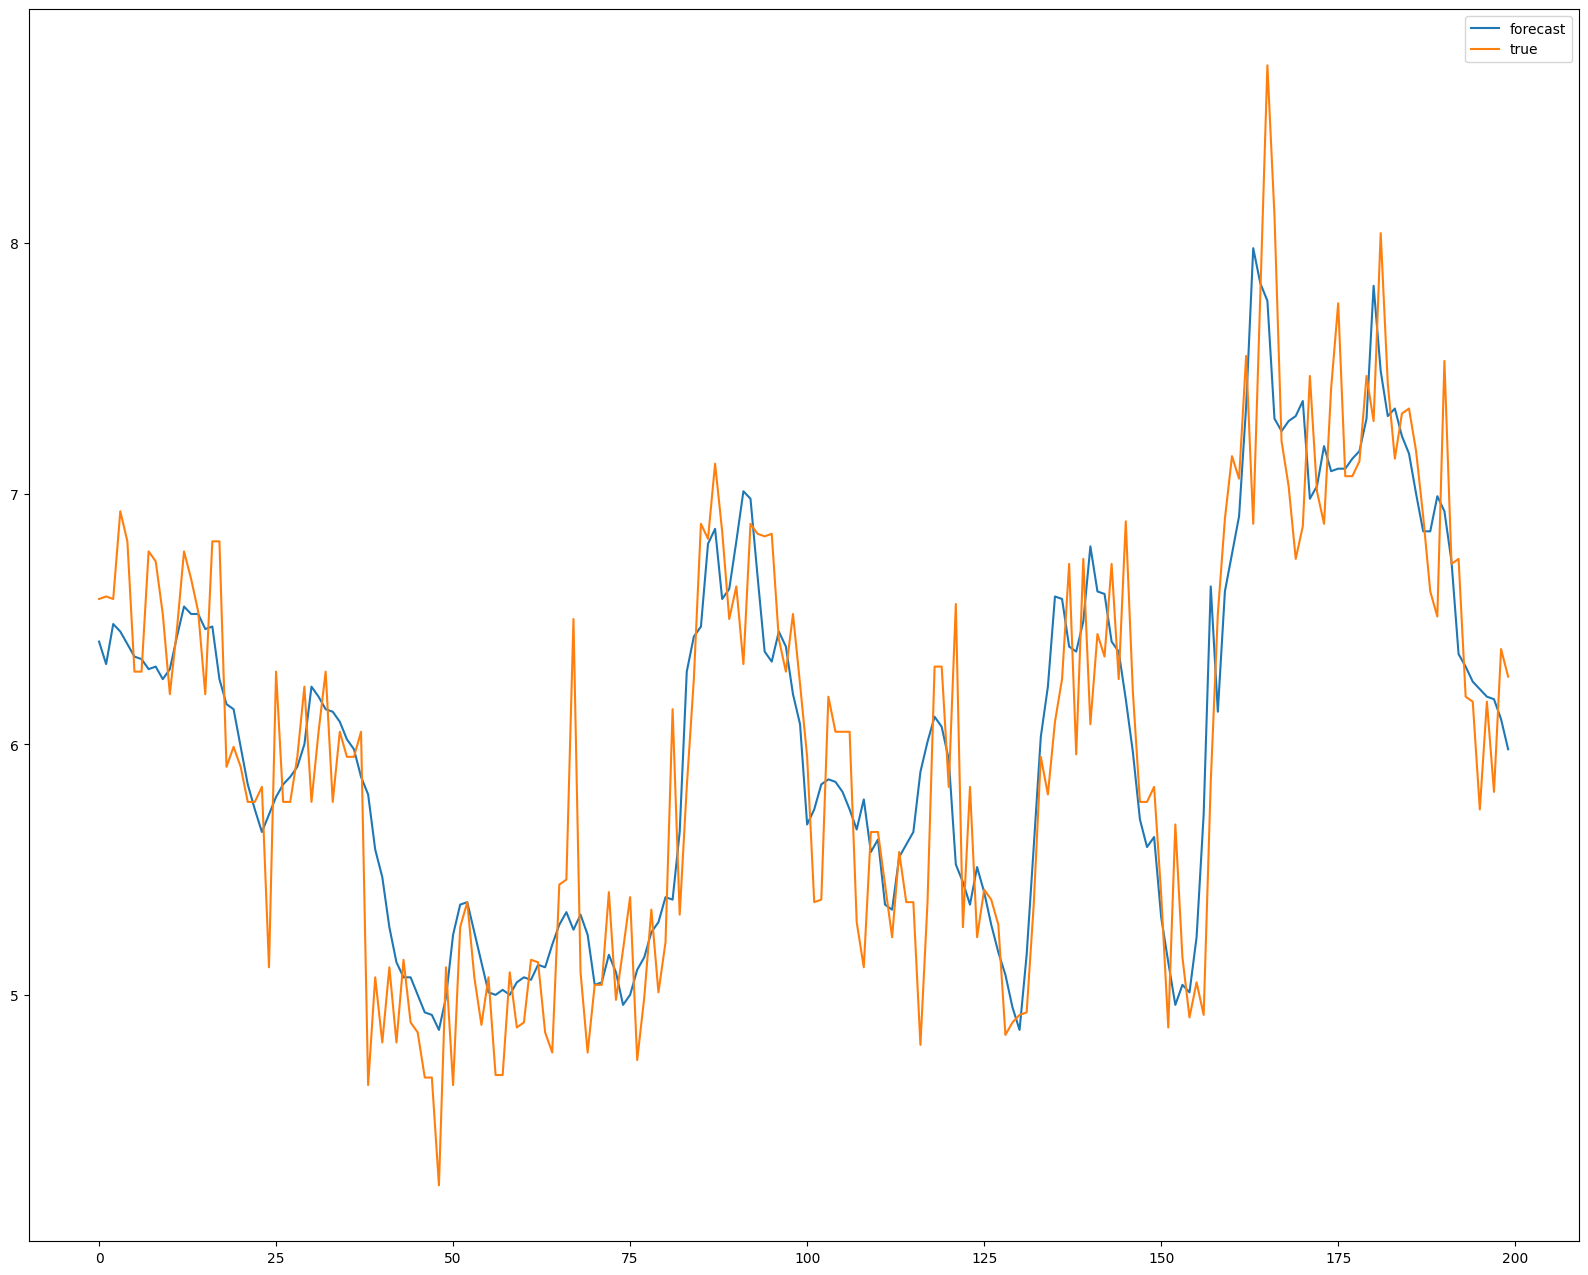

MSE: 0.5756712287712288
RMSE: 0.7587300104590755
MAE: 0.5312558869701727
Analyzing predictions for VPdef (mbar)


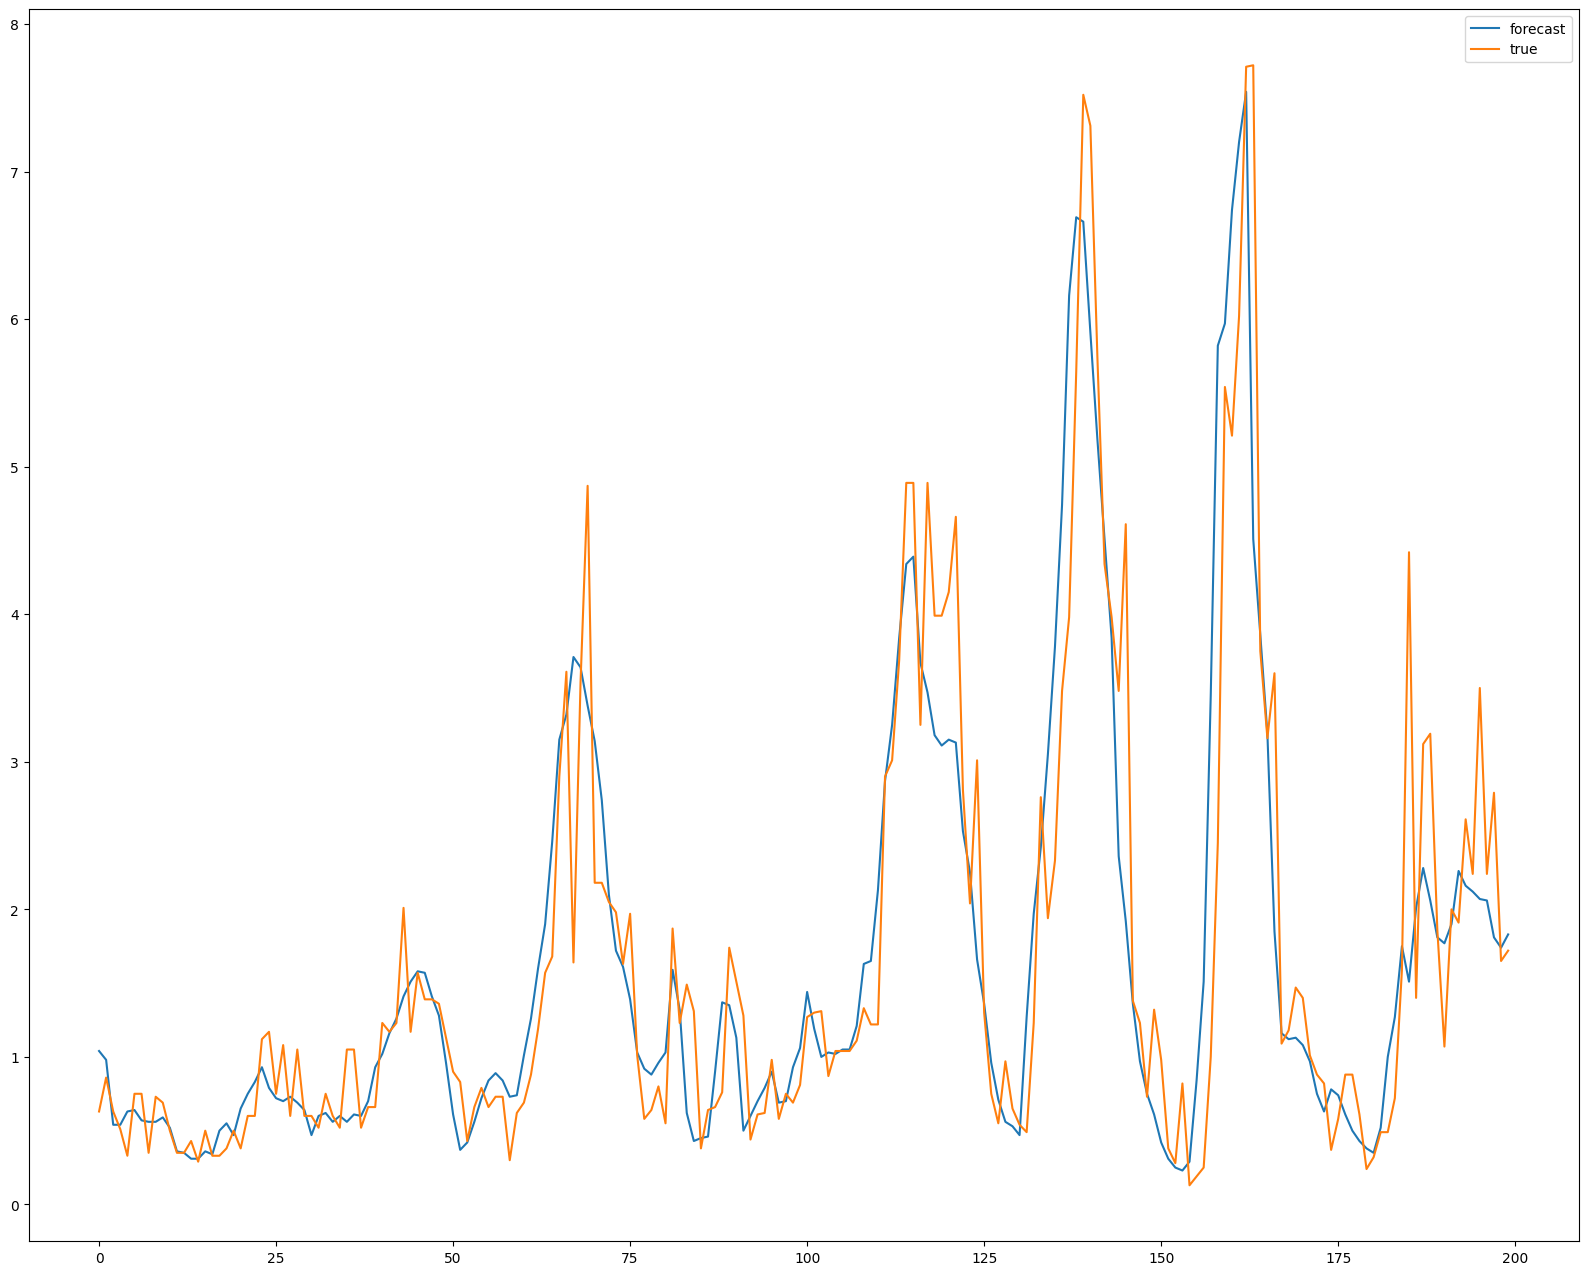

MSE: 3.107273840445269
RMSE: 1.7627461077663082
MAE: 1.0889139431996575
Analyzing predictions for sh (g/kg)


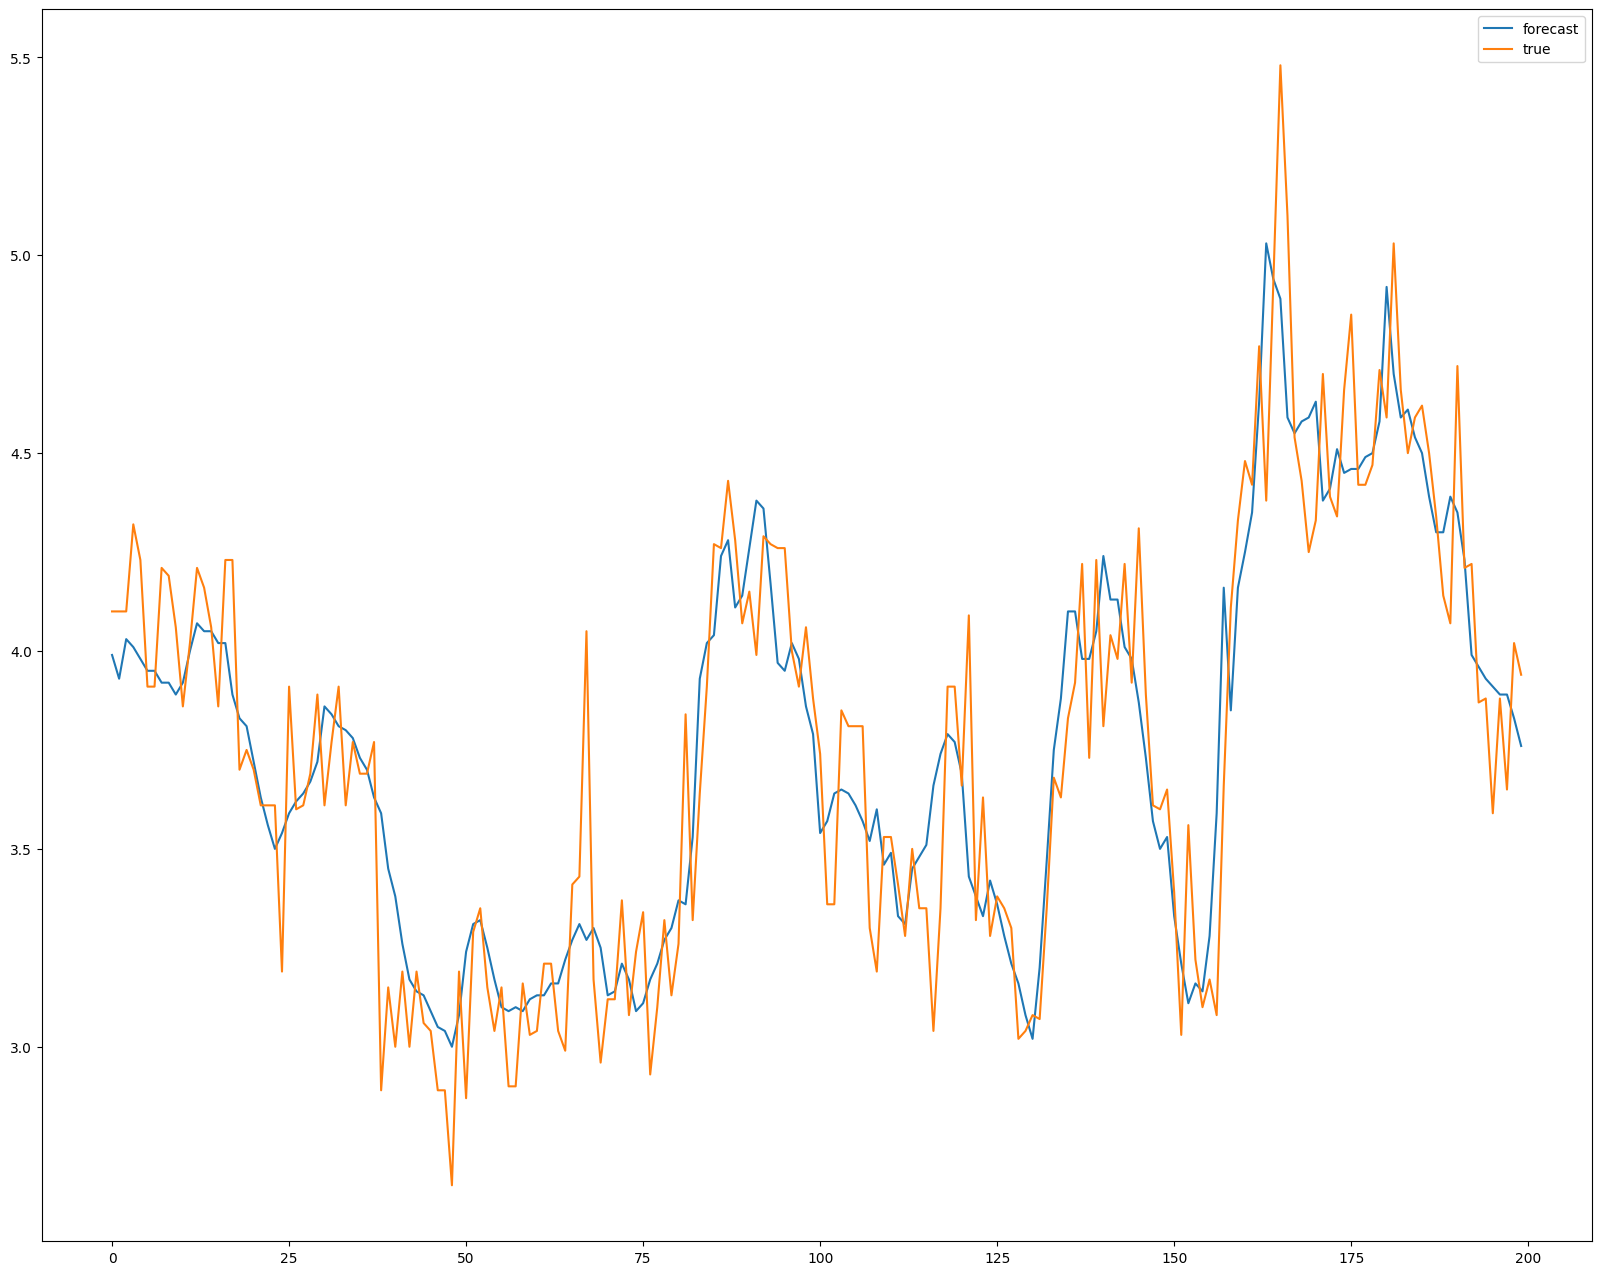

MSE: 0.227350592264878
RMSE: 0.47681295312195326
MAE: 0.33223633509347794
Analyzing predictions for H2OC (mmol/mol)


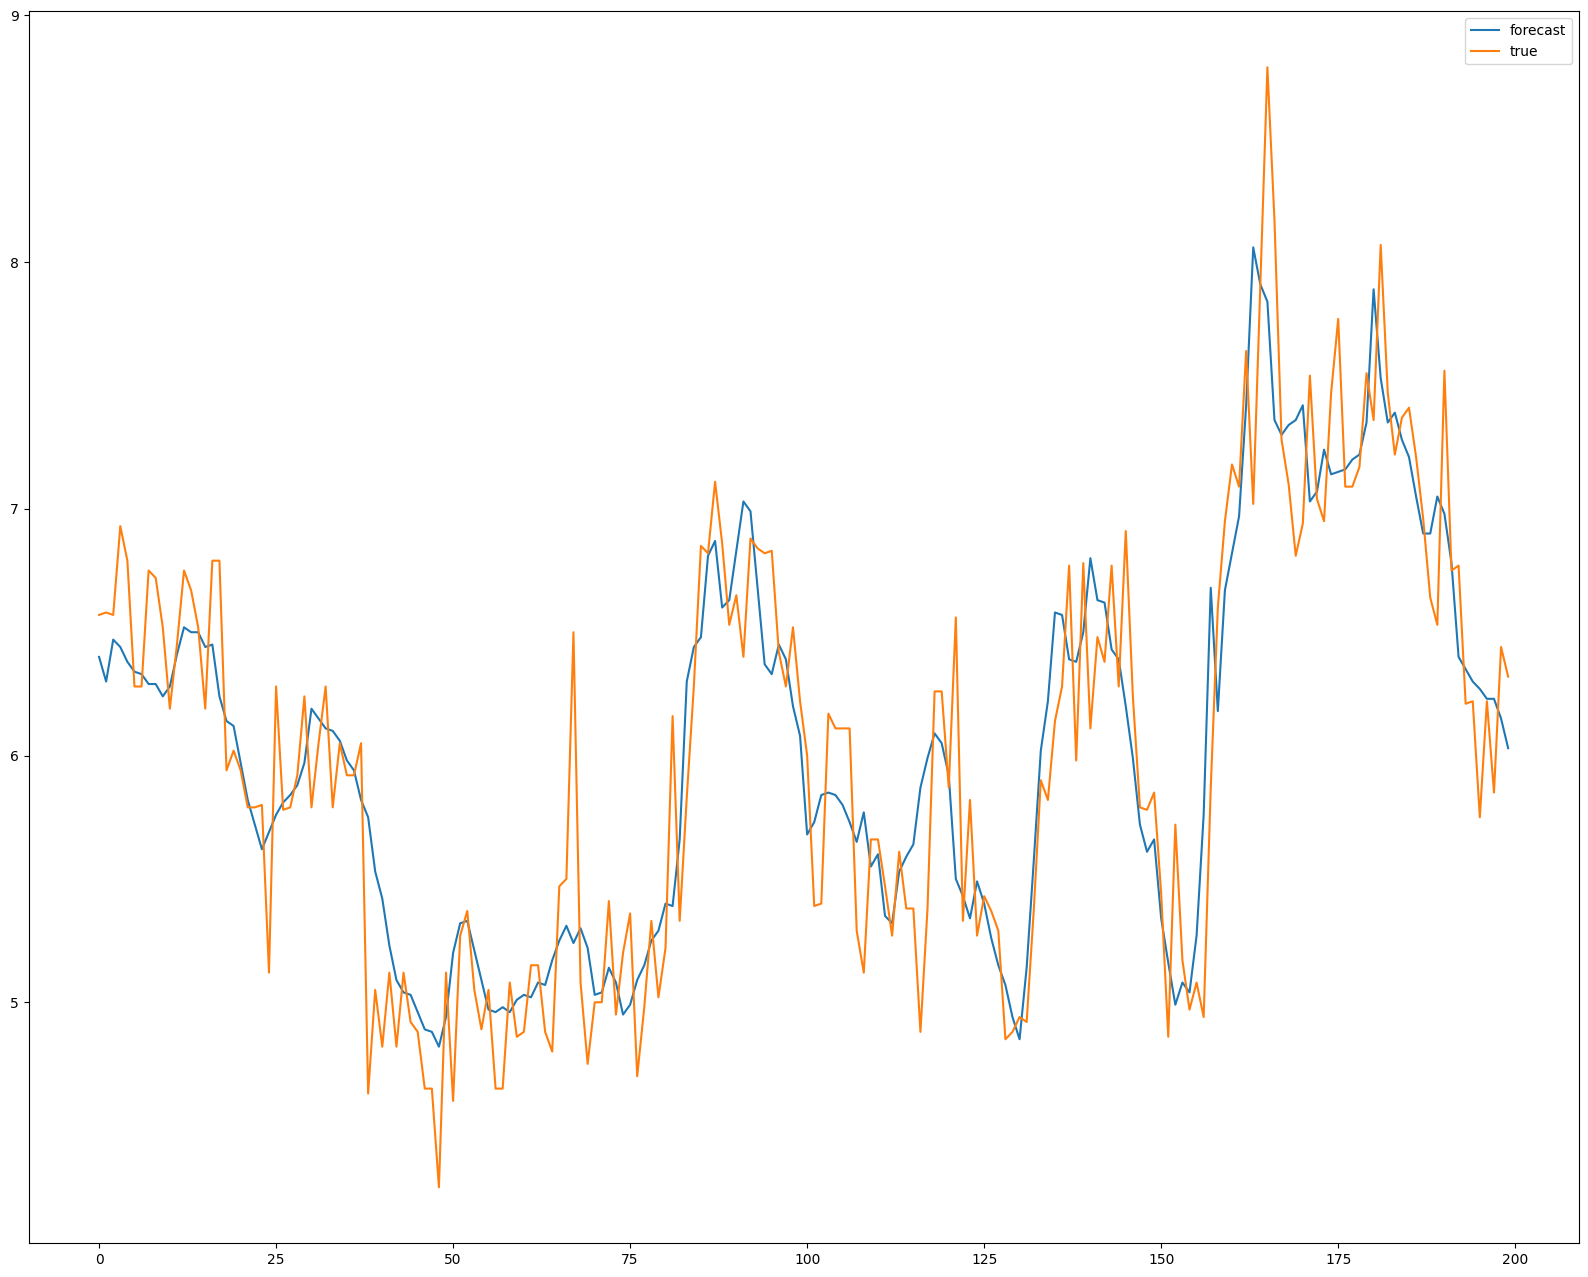

MSE: 0.5755554160125589
RMSE: 0.758653686481888
MAE: 0.529239332096475
Analyzing predictions for rho (g/m**3)


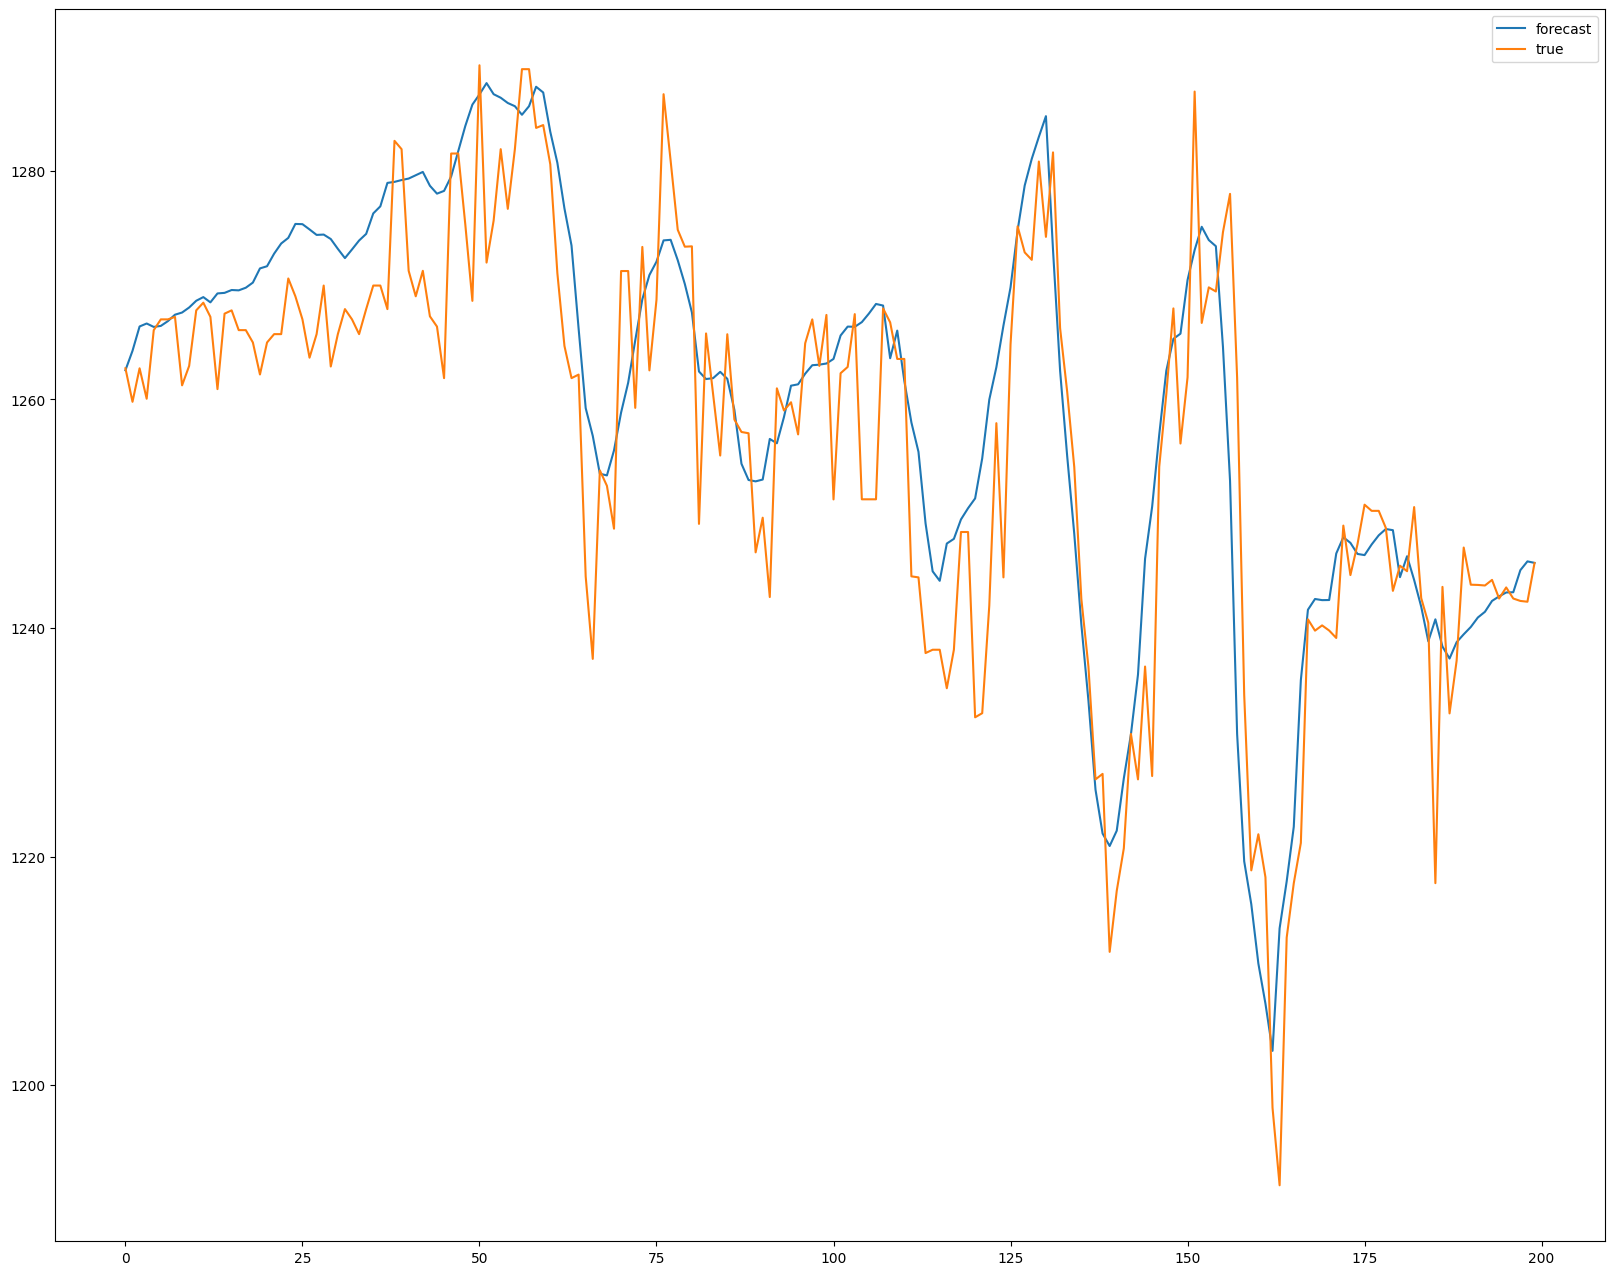

MSE: 60.96930382474669
RMSE: 7.808284307371671
MAE: 6.050476666190952
Analyzing predictions for wv (m/s)


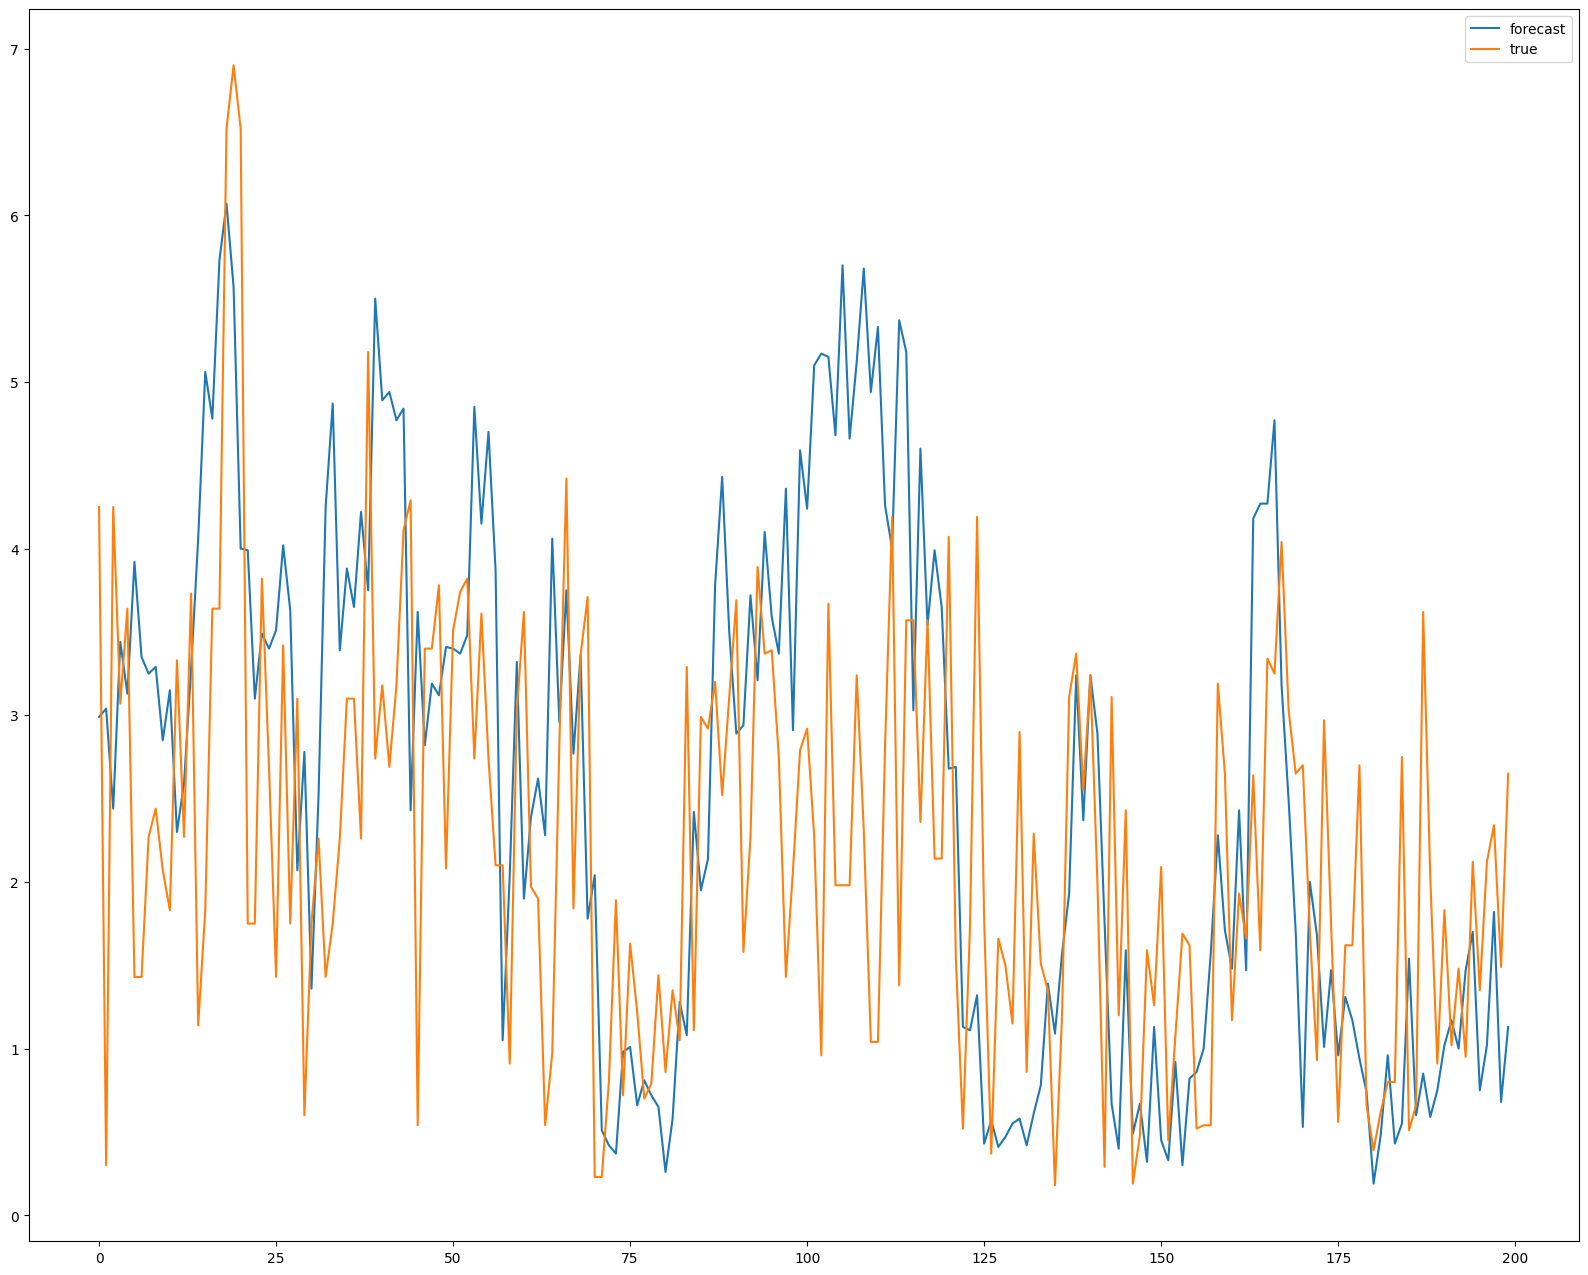

MSE: 1.706736434993578
RMSE: 1.3064212318366455
MAE: 0.9668445839874412
Analyzing predictions for max. wv (m/s)


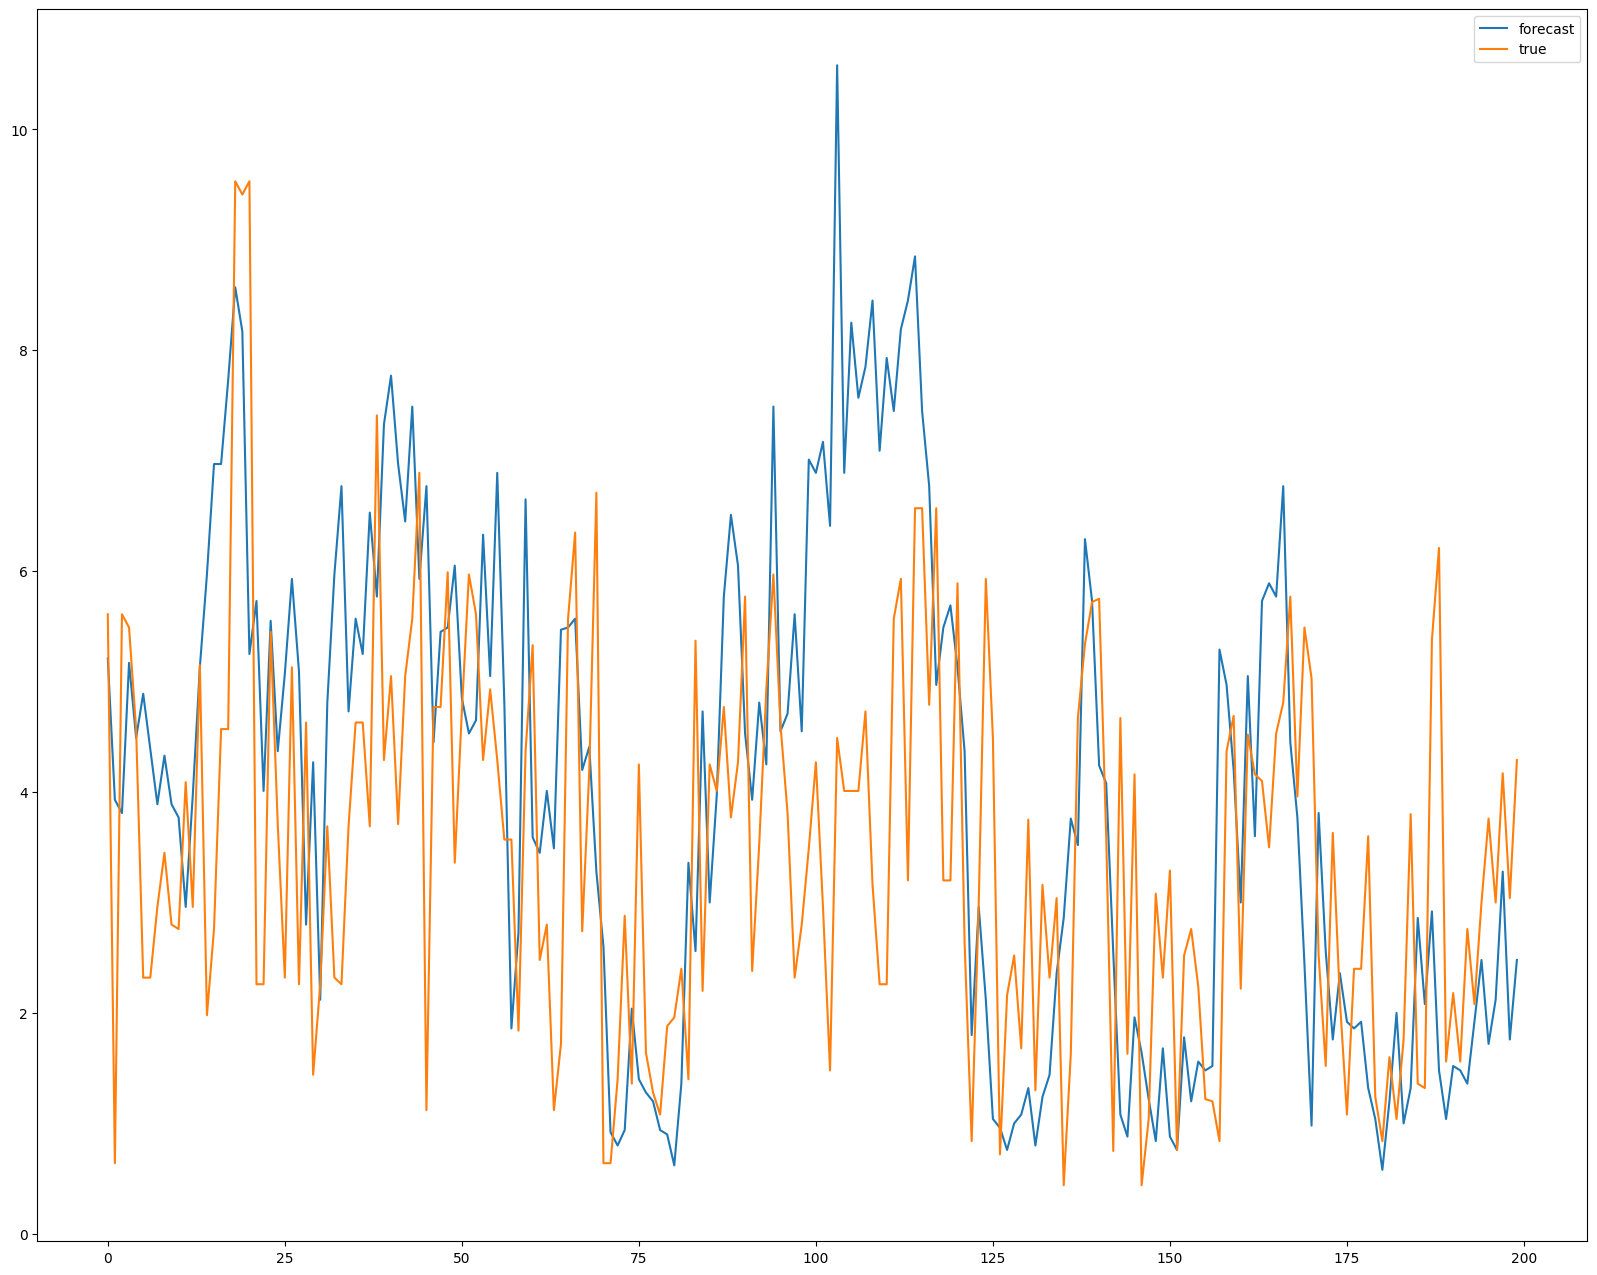

MSE: 3.9876014842300553
RMSE: 1.9968979654028534
MAE: 1.4857228485799914
Analyzing predictions for wd (deg)


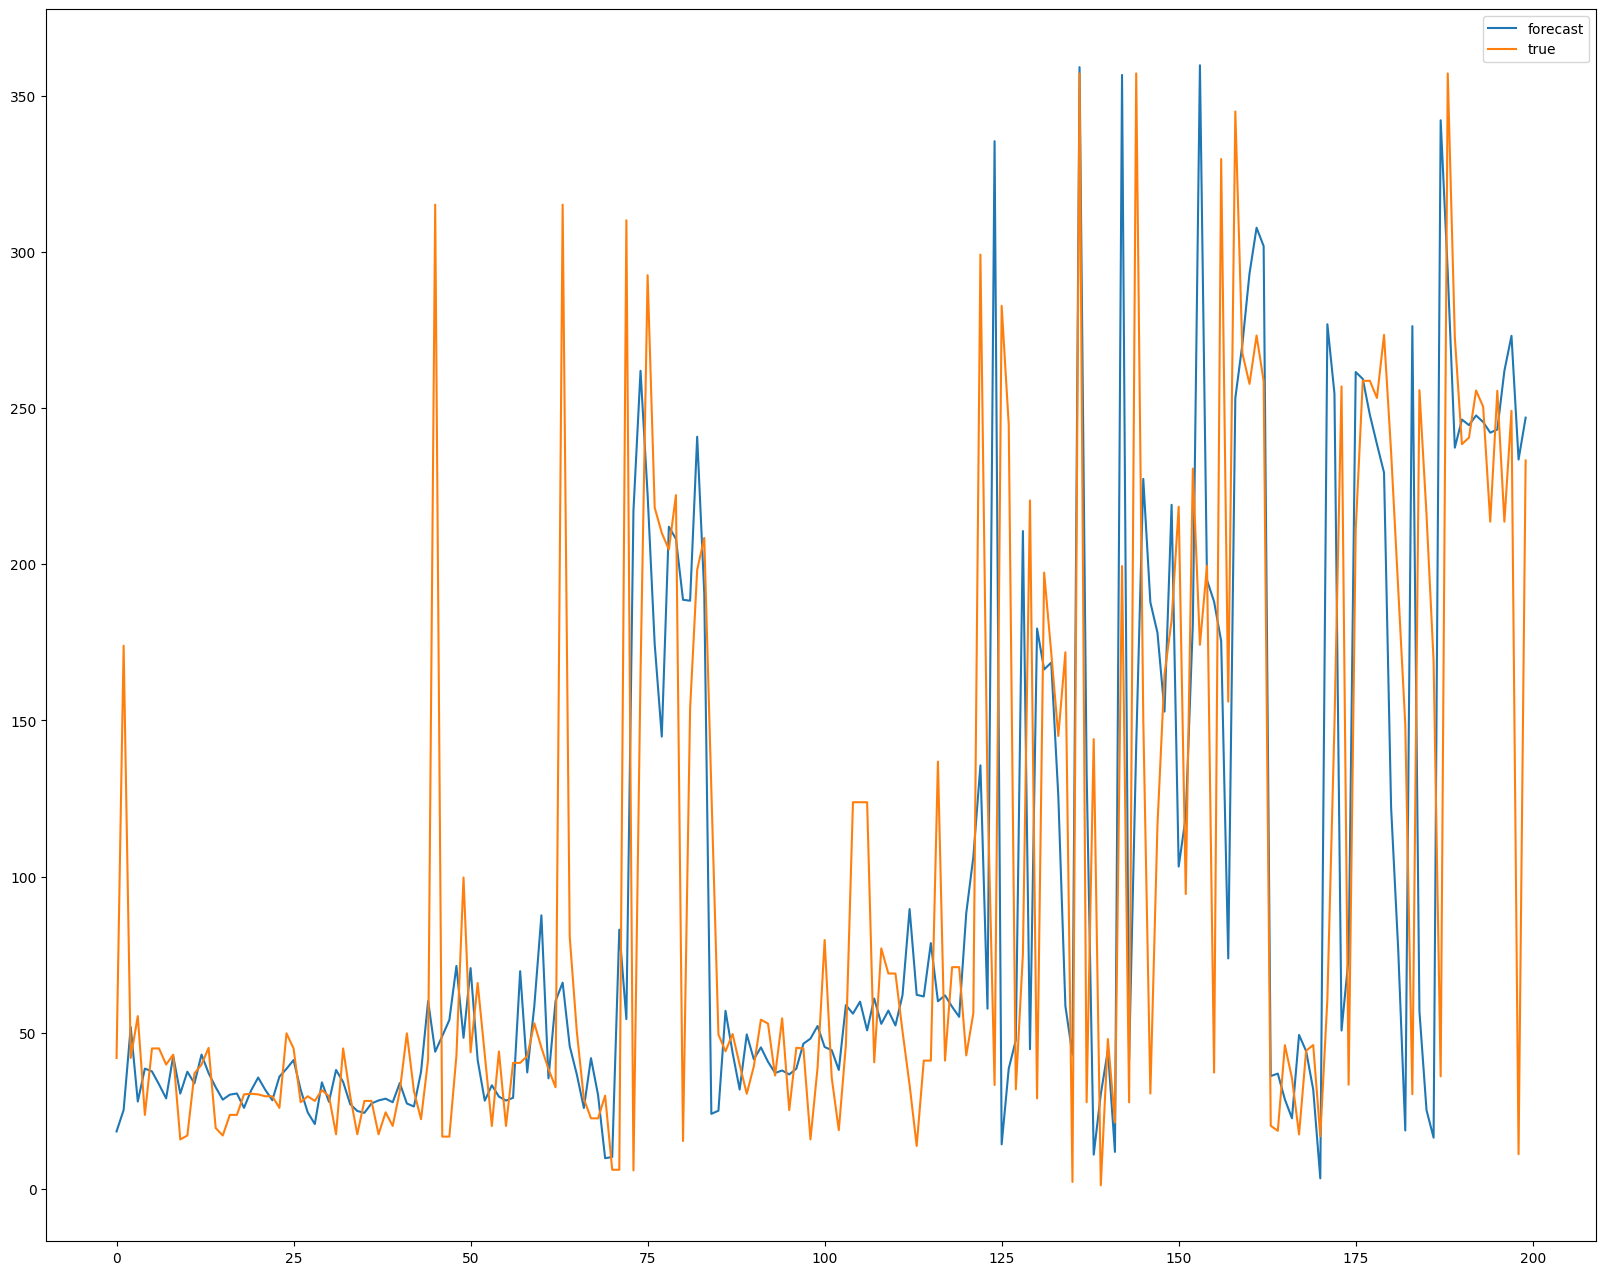

MSE: 9473.1549142429
RMSE: 97.33013363929436
MAE: 62.865707149992865


In [ ]:
for feature in original_data_for_insert.columns[1:]:
    print(f'Analyzing predictions for {feature}')
    true_values, predicted_values = get_predictions(feature)
    plot_results(true_values, predicted_values)
    print_results(true_values, predicted_values)

# Conclusion

From the plots above we can see that this vector search method is able to predict some features pretty accurately (VPdef, VPmax, rh(%) etc.), some pretty accurately (H20C, rho), and other features are not predicted that well (wd, max.vv, wv).

And that's how powerful even such a straightforward search can be!



### Cleanup

In [ ]:
# Close the postgres connection
conn.close()